# Überprüfung der Erzeugung von Trackausschnitten

Manchmal sehen die Trackauschnitte so aus, als wäre es keine konvektiven Wolken. Vielleicht ist das nur ein Artefakt eines Fehlers bei der Ausschnittserzeugung. Das wird im Folgenden an einem Beispiel überprüft.

In [1]:
import sys
import pandas as pd
import datetime as dt

import pandas as pd

from l15_msevi.msevi import MSevi
from l15_msevi.msevi_config import _narrow_channels

import MSGtools
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

sys.path.append("/vols/talos/home/stephan/utils")
import remap_grid as rg
import radar_cmap
cmap_rado, norm_rado = radar_cmap.radar_cmap()
import read_linet_data as rld

import xarray as xr
import geooperations as go

import numpy as np 

from analysis_tools import make_hrv_upscaling as mhu
from analysis_tools import grid_and_interpolation as gi

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
pfad = "/vols/talos/home/stephan/test/haci/bin"
radarpfad = "/vols/talos/datasets/radolan/rx_hdcp2/"
speicherpfad = "/vols/talos/home/stephan/data/radar_track/trackdata"

In [4]:
datenfelder = _narrow_channels + ['HRV'] + ['Z']

In [5]:
# Umgebungsboxkoordinaten erstellen
def obj2bbox(obj,nt=13,nl=75,nc=75):
    # time slice
    t0 = obj.t0-(nt/2)
    t1 = obj.t0+(nt-nt/2)
    ts = slice(t0,t1)
    # line slice
    l0 = obj.l00-(nl-(obj.l01-obj.l00))/2
    l1 = l0+nl
    ls = slice(l0,l1)
    # column slice
    c0 = obj.c00-(nc-(obj.c01-obj.c00))/2
    c1 = c0+nc
    cs = slice(c0,c1)
    return (ts,ls,cs)

Wir laden uns ein Beispiel-HACI-Objekt.

In [6]:
objects = pd.read_csv("/vols/talos/home/stephan/proj/2017-12_radartracks/haci_objects/interessante_faelle_2013.csv")

In [7]:
interesting_object = objects.iloc[43]

In [8]:
interesting_object

c0              758
c00             758
c01             764
c1              775
date     2013-06-18
dt                6
flags             0
id               88
l0              372
l00             376
l01             380
l1              380
t0              155
t1              161
time          12:55
Name: 43, dtype: object

Als nächstes laden wir die Radardaten für den Tag und erzeugen uns eine Liste mit den Zeitschritten des Tages

In [9]:
d  =interesting_object.date
rx_file = '%s/%s/hdfd_miub_drnet00_l3_dbz_v00_%s%s%s000000.nc' % (radarpfad,
                                                                  d[0:4],
                                                                  d[0:4],
                                                                  d[5:7],
                                                                  d[8:10])
            
radar_daten = xr.open_dataset(rx_file)
tliste = pd.date_range(pd.Timestamp(d), periods=288, freq='5min',tz='UTC')

Dann erzeugen wir uns die Koordinaten, die das HACI-Objekt umspannen.

In [10]:
bbox = obj2bbox(interesting_object)

In [11]:
bbox

(slice(149, 162, None), slice(341, 416, None), slice(724, 799, None))

Die ersten beiden Koordinaten geben den Zeitbereich an, das zweite Paar den Zeilenbereich und das dritte den Spaltenbereich.

In folgenden Schritt laden wir alle nötigen Daten für einen Zeitschritt. Das umfasst:

- die Linet-Blitzdaten
- die Satellitendaten
- NWCSAF-Produkte

Zuerst die Blitz, die in den letzten fünf Minuten bis zum aktuellen Zeitschrit registriert wurden.

In [12]:
time = tliste[bbox[0].start+6]

In [13]:
linet_data = rld.read_linet_for_time_intervall(time-dt.timedelta(minutes=5),time,0)

In [14]:
linet_data.head()

,time,lat,lon,type,current
672517,2013-06-18 12:50:01.510,46.433,10.780,1,-9.2
672518,2013-06-18 12:50:01.511,46.425,10.770,2,-5.4
672519,2013-06-18 12:50:02.446,49.053,13.161,2,3.1
672520,2013-06-18 12:50:05.115,48.827,13.758,2,-4.7
672521,2013-06-18 12:50:08.697,49.033,13.350,2,-3.6


Aktuell ist das nur ein Datensatz. Für die Anwendung mit den Satellitendaten wäre es eventuell gut, diese Daten auf ein Raster, wie z.B. das der Radardaten, zu bringen. Um das zu erreichen zählen wir einfach die Blitze, die in einem Pixel des Radargitters aufgetreten sind.

In [15]:
linet_grid = rld.linet2rado_frequency_grid(linet_data)

Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
Lightning outside of Radolan domain.
L

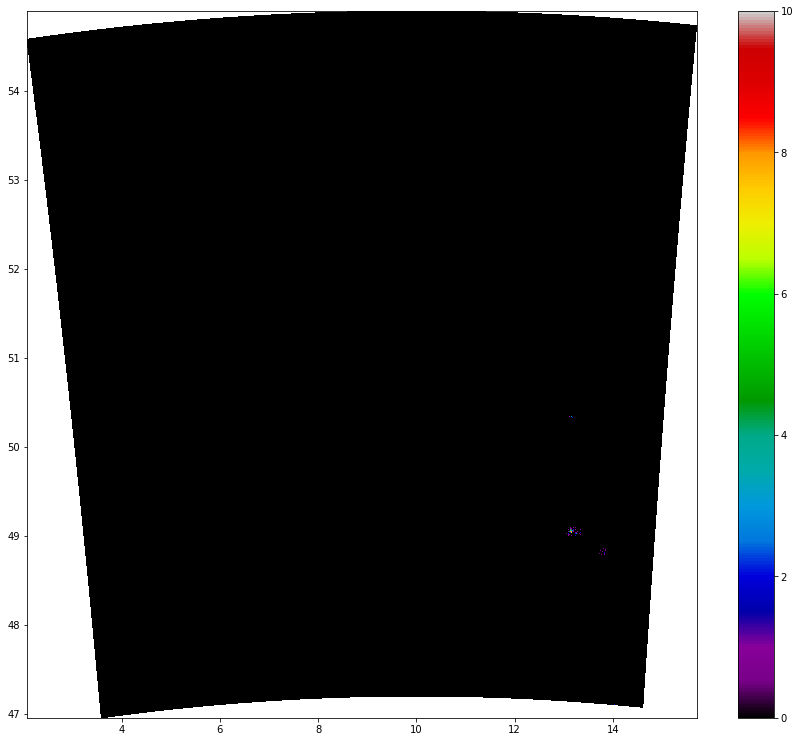

In [16]:
fig,ax = plt.subplots(1,1,figsize=(15,13))
blitz_plot = ax.pcolormesh(radar_daten.lon.data,radar_daten.lat.data,linet_grid,
                          cmap='nipy_spectral')
plt.colorbar(blitz_plot)

In den letzten fünf Minuten gab es vor allem Blitze am Bayerischen Wald und am Erzgebirge mit maximal 10 fl/km².

Als nächstes laden wir die Satellitendaten.

In [17]:
s = MSevi(time = time.to_pydatetime(),region='eu',scan_type='rss',
                          chan_list = _narrow_channels + ["HRV"])
s.rad2bt()
s.rad2refl()
s.lonlat()

Region suggests use of hdf file


Und danach die NWCSAF Wolkenmaske und Wolkenhöhe, die wir auch für die Parallaxenkorrektur brauchen.

In [18]:
ch = MSGtools.get_nwcsaf_prod('CTTH_HEIGHT',time.to_pydatetime(),calibrate=True,region='eu')
cma = MSGtools.get_nwcsaf_prod('CMa',time.to_pydatetime(),calibrate=True,region='eu')

Da wir auch die HRV-Daten parallaxenkorrigieren müssen, müssen wir Wolkenmaske und -höhe auch auf die HRV-Auflösung interpolieren.

In [19]:
ch_hrv = mhu.make_hrv_upscaling(ch)
cma_hrv = mhu.make_hrv_upscaling(cma)

Damit können wir jetzt die Satellitendaten parallaxenkorrigieren.

In [20]:
felder_korr = {k:[] for k in datenfelder[:-1]}

In [151]:
for k in datenfelder[:-1]:
    if k == 'HRV':
        res = k.lower()
        slon = s.hlon
        slat = s.hlat
        cth = ch_hrv

    else:
        res = 'std'
        slon = s.lon
        slat = s.lat
        cth = ch

    if k in  ['VIS006', 'VIS008', 'IR_016','HRV']:
        feld = go.parallax_correct_msg(np.clip(s.ref[k],0,1),
                                       slon,slat,cth,
                                       res,'eu','rss',1)

        felder_korr[k] = feld
    else:
        feld = go.parallax_correct_msg(s.bt[k],
                                       slon,slat,cth,
                                       res,'eu','rss',1)

        felder_korr[k] = feld

Text(0.5,1,u'mit Parallaxenkorrektur')

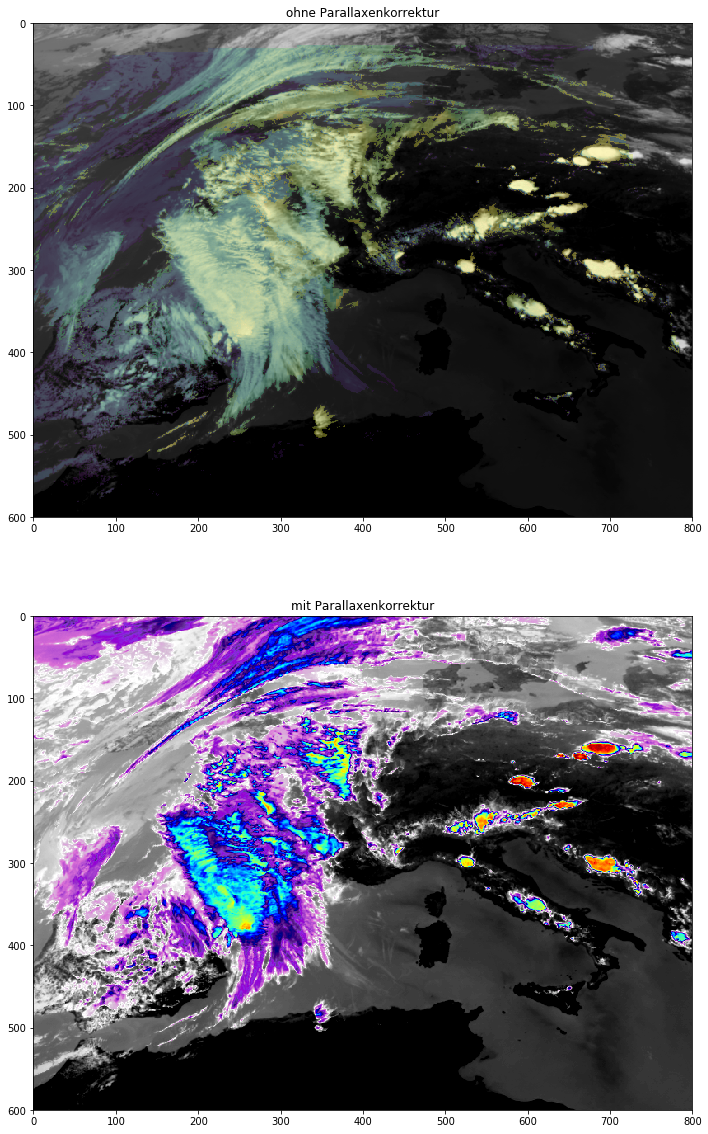

In [22]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
unkorr_plot = ax[0].imshow(s.bt['IR_108'], vmin=210,vmax=300,cmap='gray_r')
cma_plot = ax[0].imshow(np.ma.masked_less(ch,1),vmin=0,vmax=12000,alpha=0.3)
#plt.colorbar(cma_plot)
ax[0].set_title(u"ohne Parallaxenkorrektur")
korr_plot = ax[1].imshow(felder_korr['IR_108'], vmin=210,vmax=300,cmap=emap)
ax[1].set_title(u"mit Parallaxenkorrektur")

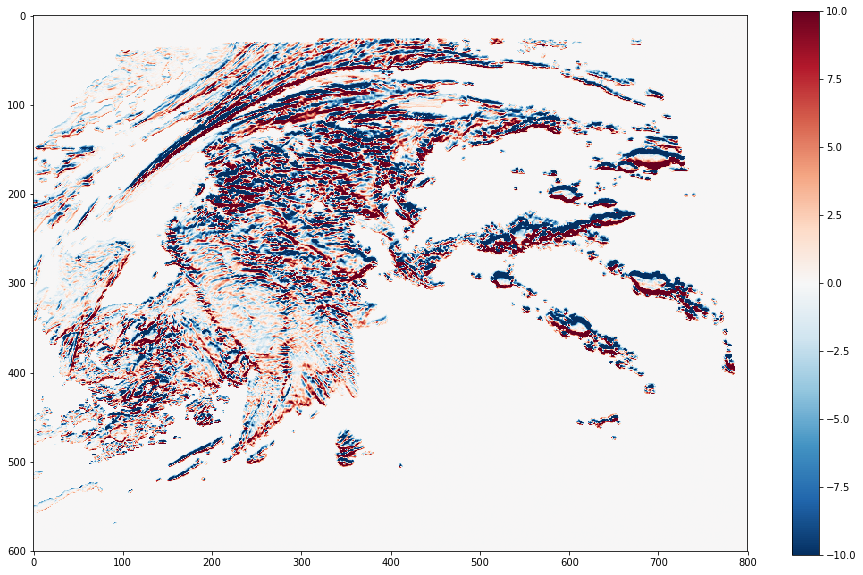

In [23]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
diff_plot = ax.imshow(s.bt['IR_108'] - felder_korr['IR_108'], vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(diff_plot)

Das sieht auf den ersten Blick gut aus. Aber wir sollten uns das nochmal im Detail ansehen.

In [24]:
ir108_cutout = s.bt['IR_108'][190:220,570:620]
korr_cutout = felder_korr['IR_108'][190:220,570:620]
diff_cutout = s.bt['IR_108'] - felder_korr['IR_108']
diff_cutout = diff_cutout[190:220,570:620]

Text(0.5,1,'Differenz')

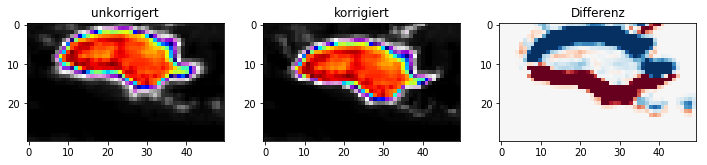

In [25]:
fig,ax = plt.subplots(1,3,figsize=(12,30))
ax[0].imshow(ir108_cutout,vmin=210,vmax=300,cmap=emap)
ax[0].set_title(u"unkorrigert")
ax[1].imshow(korr_cutout,vmin=210,vmax=300,cmap=emap)
ax[1].set_title(u"korrigiert")
ax[2].imshow(diff_cutout,vmin=-15,vmax=15,cmap='RdBu_r')
ax[2].set_title("Differenz")

OK, das scheint zu funktionieren. Die Wolke wird nach Süden verschoben. Der Nordrand hat in der Differenz einen negativen Wert, weil die Pixel dort jetzt wärmer geworden sind und der Südrand einen positiven Rand, weil die Differenz positiv ist. Denn hier wurden kältere Pixel hingeschoben.

Als nächstes schneiden wir nur die Bereiche aus, die uns wirklich interessieren: den Bereich des HACI-Objektes. Da die Felder unterschiedliche Auflösungen und Georeferenzen haben, sollten wir die Umgebungskoordinten des HACI-Objektes entsprechend umrechnen.

In [26]:
start_lon = radar_daten.lon.data[bbox[1].start,bbox[2].start]
start_lat = radar_daten.lat.data[bbox[1].start,bbox[2].start]
stop_lon = radar_daten.lon.data[bbox[1].stop,bbox[2].stop]
stop_lat = radar_daten.lat.data[bbox[1].stop,bbox[2].stop]

start_row,start_col = gi.get_index((start_lon,start_lat), s.lon,s.lat)
stop_row,stop_col = gi.get_index((stop_lon,stop_lat), s.lon,s.lat)

start_hrow,start_hcol = gi.get_index((start_lon,start_lat), s.hlon,s.hlat)
stop_hrow,stop_hcol = gi.get_index((stop_lon,stop_lat), s.hlon,s.hlat)

lon_ausschnitt = s.lon[stop_row:start_row,start_col:stop_col]
lat_ausschnitt = s.lat[stop_row:start_row,start_col:stop_col]

hlon_ausschnitt = s.hlon[stop_hrow:start_hrow,start_hcol:stop_hcol]
hlat_ausschnitt = s.hlat[stop_hrow:start_hrow,start_hcol:stop_hcol]

rlon_ausschnit = radar_daten.lon.data[bbox[1].start:bbox[1].stop,bbox[2].start:bbox[2].stop]
rlat_ausschnitt = radar_daten.lat.data[bbox[1].start:bbox[1].stop,bbox[2].start:bbox[2].stop]

In [27]:
from matplotlib import patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [152]:
std_w = stop_lon - start_lon
std_h = stop_lat - start_lat

rect_std = patches.Rectangle((start_lon,start_lat),std_w,std_h,linewidth=2,edgecolor='magenta',facecolor='none',
                             transform=ccrs.PlateCarree())
rect_std1 = patches.Rectangle((start_lon,start_lat),std_w,std_h,linewidth=2,edgecolor='magenta',facecolor='none',
                               transform=ccrs.PlateCarree())

In [68]:
borders_10m = cfeature.NaturalEarthFeature('cultural',
                                           'admin_0_countries',
                                           '10m',
                                           facecolor=None)

In [39]:
msg_crs = ccrs.Geostationary(central_longitude=9.5,
                             satellite_height=35785831,
                             false_easting=0,
                             false_northing=0,
                             globe=None,
                             sweep_axis='y')

Text(0.5,1,'mit Parallaxenkorrektur')

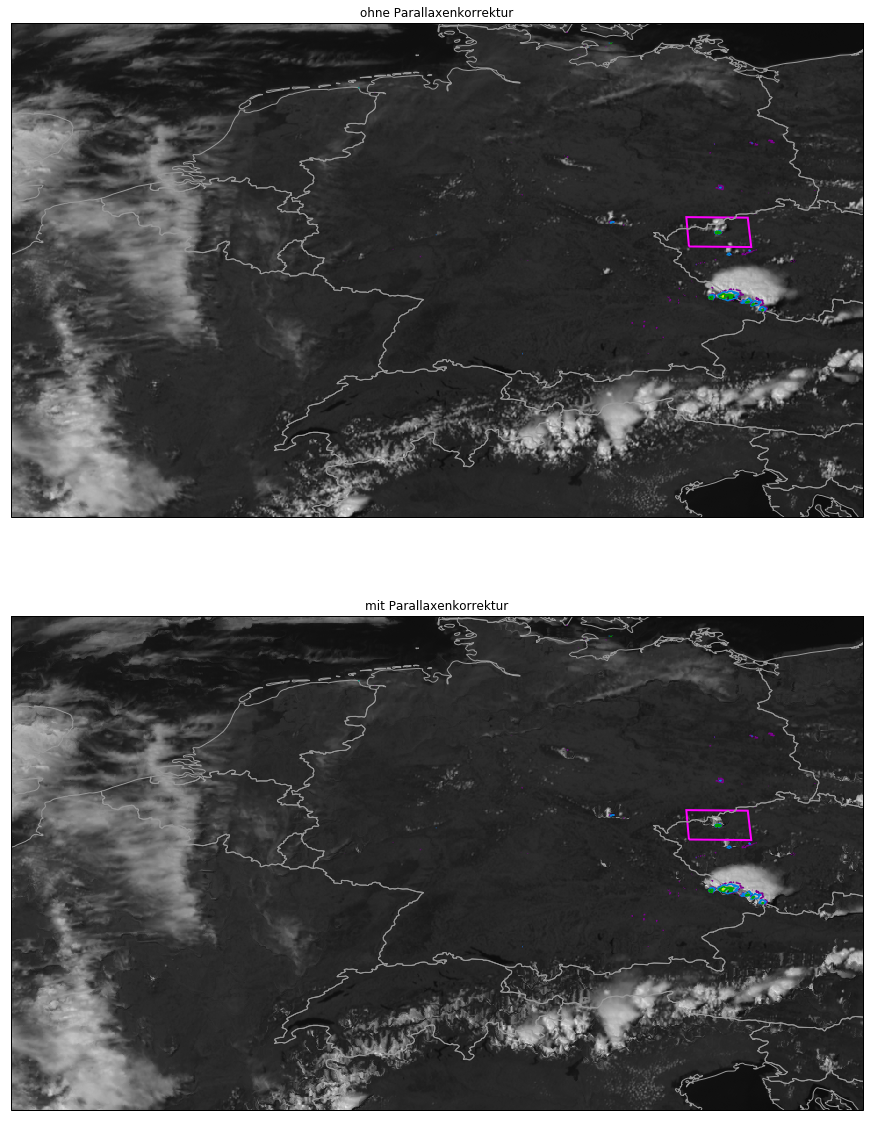

In [153]:
fig = plt.figure(figsize=(16,20))
ax0 = fig.add_subplot(2,1,1,projection= msg_crs)
ax0.set_extent([2,15,45,55])
ax0.add_feature(borders_10m,color=(0.6,0.6,0.6,1),facecolor=(1,0.5,1,0))
ax0.pcolormesh(s.hlon,
              s.hlat,
              s.ref['HRV'],
              vmin=0,
              vmax=1,
              cmap='gray',
              transform=ccrs.PlateCarree())

ax0.contour(radar_daten.lon,
           radar_daten.lat,
           np.ma.masked_less(radar_daten.dbz.data[bbox[0].start+6],10),
           vmin=10,vmax=85,cmap='nipy_spectral',
           transform=ccrs.PlateCarree())

ax0.add_patch(rect_std)
ax0.set_title("ohne Parallaxenkorrektur")

ax1 = fig.add_subplot(2,1,2,projection= msg_crs)
ax1.set_extent([2,15,45,55])
ax1.add_feature(borders_10m,color=(0.6,0.6,0.6,1),facecolor=(1,0.5,1,0))

ax1.pcolormesh(s.hlon,
               s.hlat,
               felder_korr['HRV'],
              vmin=0,
              vmax=1,
              cmap='gray',
              transform=ccrs.PlateCarree())

ax1.contour(radar_daten.lon,
           radar_daten.lat,
           np.ma.masked_less(radar_daten.dbz.data[bbox[0].start+6],10),
           vmin=10,vmax=85,cmap='nipy_spectral',
           transform=ccrs.PlateCarree())

ax1.add_patch(rect_std1)
ax1.set_title("mit Parallaxenkorrektur")

Der Ausschnitt scheint auch zu passen. Da entwickelt sich entlang des Erzgebirges eine neue konvektive Wolke 
und fängt an Niederschlag zu produzieren.